In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from ggplot import *
import pandas as pd
from sklearn.manifold import TSNE
import time

import matplotlib.pyplot as plt
%matplotlib inline

/anaconda2/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/anaconda2/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


In [2]:
# function to load data
def read_hero(filepath):
    with open(filepath, 'r') as f:
        hero_powers = {}
        heroes = []
        
        for line in f.readlines()[1:]:    # header excluded
            line = line.strip().split(',')
            name = line[0].lower()
            powers = np.array([0 if power=='False' else 1 for power in line[1:]], dtype=np.int) # convert 'False'/'True' to one-hot
            heroes.append(name)
            hero_powers[name] = powers
    return np.array(heroes), hero_powers

In [3]:
heroes, hero_powers = read_hero('./superhero-set/super_hero_powers.csv')

In [4]:
# function to compute cosine similarity
def cosine_similarity(x, y):
    cosine_sim = np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))
    return cosine_sim

In [5]:
# compare the similarity between super heroes
batman = hero_powers['batman']
ironman = hero_powers['iron man']
print(cosine_similarity(batman, ironman))

0.5292561240249631


In [6]:
# find the most similar super hero by his/her abilities

def find_similar_hero(hero):
    max_similarity = -100
    sim_hero = None
    
    for h in hero_powers.keys():
        if h == hero:
            continue
        sim = cosine_similarity(hero_powers[h], hero_powers[hero.lower()])
        if sim > max_similarity:
            max_similarity = sim
            sim_hero = h
    sim_hero = (' ').join([n.capitalize() for n in sim_hero.split()])
    return sim_hero

In [7]:
# let's do some interesting searches
def find_heroes(heroes):
    for h in heroes:
        result = find_similar_hero(h)
        print("The most similar hero of {} is {}.".format((' ').join([n.capitalize() for n in h.split()]), result))

In [8]:
targets = ['batman', 'spider-man', 'captain america', 'aquaman', 'superman', 'black widow', 'hawkeye']
find_heroes(targets)

The most similar hero of Batman is Punisher.
The most similar hero of Spider-man is Silk.
The most similar hero of Captain America is Punisher.
The most similar hero of Aquaman is Namor.
The most similar hero of Superman is Supergirl.
The most similar hero of Black Widow is Red Hood.
The most similar hero of Hawkeye is Green Arrow.


In [9]:
# Now, let's divide these heroes into different clusters based on their abilities
# K-Means will be used for this task
# let's make the hero data into a vector and check its shape

def hero_vector(pathfile):
    with open(pathfile, 'r') as f:
        h_vector = []
        
        for line in f.readlines()[1:]:
            line = line.strip().split(',')
            h_data = np.array([0 if x == 'False' else 1 for x in line])
            h_vector.append(h_data)
    h_vector = np.array(h_vector)
    return h_vector

In [10]:
h_vector = hero_vector('./superhero-set/super_hero_powers.csv')
print(h_vector.shape)

(667, 168)


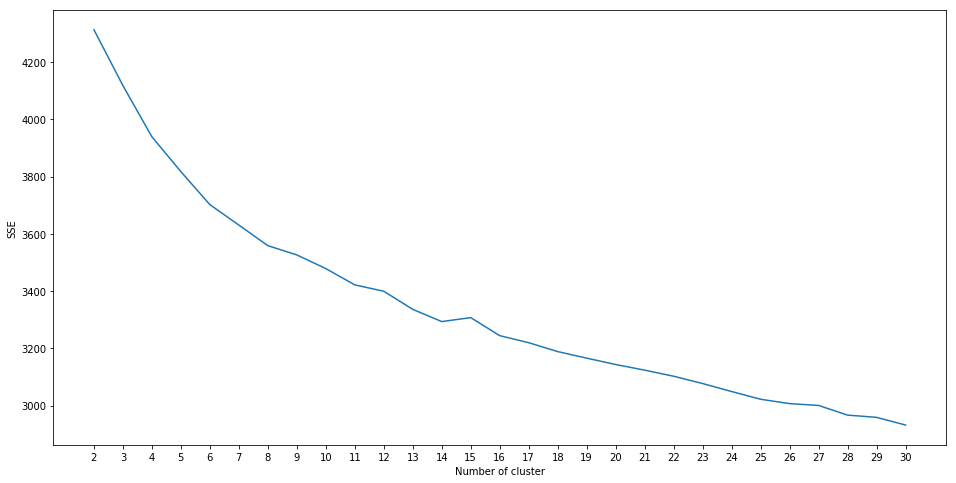

In [33]:
# Since the cluster number (k) is required for KMeans clustering model and the simplest way characterizing it is by elbow plotting
# We'll try a range of ks for the KMeans model and find out the very one making the sum of squared error (SSE) as an elbow value

sse = {}
for k in range(2, 31):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(h_vector)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure(figsize=(16,8))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.xticks(np.arange(2, 31))
plt.show()

In [34]:
# Thus, the SSE is at elbow when k=16
best_k = 10

In [35]:
# Let's do the clustering and get the labels and centeroids
best_kMeans = KMeans(n_clusters=best_k, max_iter=1000).fit(h_vector)
k_means_labels = best_kMeans.labels_
k_means_cluster_centers = best_kMeans.cluster_centers_

In [36]:
# Find out how many heroes are for each cluster
cluster_to_number = {}
number_to_cluster = {}
for i in range(best_k):
    hero_group = k_means_labels[k_means_labels == i]
    cluster_to_number[i] = hero_group.shape[0]
    number_to_cluster[hero_group.shape[0]] = i

In [37]:
print(cluster_to_number)
print(number_to_cluster)

{0: 76, 1: 31, 2: 60, 3: 31, 4: 22, 5: 63, 6: 19, 7: 22, 8: 224, 9: 119}
{224: 8, 76: 0, 19: 6, 22: 7, 119: 9, 31: 3, 60: 2, 63: 5}


In [38]:
# Convert the labeled hero data to a pandas data frame
def makeDF(filepath):
    with open(filepath, 'r') as f:
        header = f.readlines()[0].strip().split(',')
        hero_dict = {}
        hero_dict[header[0]] = heroes
        for i in range(len(header[1:])):
            hero_dict[header[1:][i]] = h_vector[:,i]
        hero_dict['label'] = [str(i) for i in k_means_labels]
        df = pd.DataFrame(hero_dict)
    return df

In [39]:
hero_df = makeDF('./superhero-set/super_hero_powers.csv')

In [40]:
hero_df.head()

,Accelerated Healing,Adaptation,Agility,Animal Attributes,Animal Control,Animal Oriented Powers,Animation,Anti-Gravity,Astral Projection,Astral Travel,...,Vitakinesis,Wallcrawling,Water Control,Weapon-based Powers,Weapons Master,Weather Control,Web Creation,Wind Control,hero_names,label
0,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,3-d man,0
1,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,a-bomb,9
2,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,abe sapien,3
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,abin sur,8
4,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,abomination,9


In [41]:
# find out the group with the most heroes and the one with the least heroes
max_label = number_to_cluster[max(cluster_to_number.values())]
min_label = number_to_cluster[min(cluster_to_number.values())]
print("Cluster {} has the most heroes as {}.".format(max_label, cluster_to_number[max_label]))
print("Cluster {} has the least heroes as only {}.".format(min_label, cluster_to_number[min_label]))

Cluster 8 has the most heroes as 224.
Cluster 6 has the least heroes as only 19.


In [42]:
def selected_heroes(label, num=None):
    selected_df = hero_df[hero_df['label'] == str(label)]
    # choose random num heroes from df_common
    s = np.arange(selected_df.shape[0])
    np.random.shuffle(s)
    selected_df = selected_df.iloc[s[:num]]
    return selected_df

In [43]:
# let's see what the most common heroes can do
# we choose random 3 heroes
df_common = selected_heroes(max_label, 3)
df_common

,Accelerated Healing,Adaptation,Agility,Animal Attributes,Animal Control,Animal Oriented Powers,Animation,Anti-Gravity,Astral Projection,Astral Travel,...,Vitakinesis,Wallcrawling,Water Control,Weapon-based Powers,Weapons Master,Weather Control,Web Creation,Wind Control,hero_names,label
176,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,daphne powell,8
291,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,hiro nakamura,8
661,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,yellowjacket,8


In [44]:
def show_selected(df):
    for i, row in df.iterrows():
        powers = [col for col in df.columns if row[col] == 1]
        print("{} have powers of {}.".format((' ').join([n.capitalize() for n in row['hero_names'].split()]), (', ').join(powers)))
        print('\n')

In [45]:
show_selected(df_common)

Daphne Powell have powers of Agility, Energy Armor.


Hiro Nakamura have powers of Agility, Enhanced Senses, Enhanced Smell.


Yellowjacket have powers of Agility, Density Control, Weapon-based Powers.




In [46]:
# let's check what the rarest heroes look like

df_rare = selected_heroes(min_label, 3)
df_rare

,Accelerated Healing,Adaptation,Agility,Animal Attributes,Animal Control,Animal Oriented Powers,Animation,Anti-Gravity,Astral Projection,Astral Travel,...,Vitakinesis,Wallcrawling,Water Control,Weapon-based Powers,Weapons Master,Weather Control,Web Creation,Wind Control,hero_names,label
354,0,0,1,0,0,0,0,0,0,1,...,1,1,0,1,0,0,0,0,krypto,6
588,1,0,1,0,1,0,0,0,0,1,...,1,1,0,0,0,0,1,0,supergirl,6
450,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,nova,6


In [47]:
show_selected(df_rare)

Krypto have powers of Agility, Astral Travel, Cryokinesis, Danger Sense, Energy Constructs, Grim Reaping, Lantern Power Ring, Melting, Nova Force, Possession, Toxin and Disease Resistance, Vision - Thermal, Vitakinesis, Wallcrawling, Weapon-based Powers.


Supergirl have powers of Accelerated Healing, Agility, Animal Control, Astral Travel, Clairvoyance, Cryokinesis, Danger Sense, Durability, Energy Constructs, Flight, Grim Reaping, Invulnerability, Lantern Power Ring, Melting, Natural Weapons, Nova Force, Possession, Reflexes, Spatial Awareness, Stealth, Super Strength, Telekinesis, Toxin and Disease Resistance, Vision - Infrared, Vision - Thermal, Vitakinesis, Wallcrawling, Web Creation.


Nova have powers of Accelerated Healing, Adaptation, Agility, Astral Travel, Cryokinesis, Danger Sense, Duplication, Echolocation, Energy Constructs, Flight, Grim Reaping, Heat Resistance, Insanity, Invulnerability, Lantern Power Ring, Magic, Natural Weapons, Possession, Power Absorption, Projectio

In [48]:
# Finally let's try to visualize the clustering of heroes
# since it is a multiple dimensional vector, we need to decrease dimensions before visualization
# try to use PCA first, decrease the dimensions to 10 (k from KMeans)

pca = PCA(n_components=10)
pca_result = pca.fit_transform(h_vector)

In [49]:
pca_result.shape

(667, 10)

In [50]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.13042745 0.07758899 0.05845771 0.03606174 0.03220157 0.02956825
 0.02578215 0.02450424 0.02184584 0.02062766]


In [51]:
# then the first 3 components cover around 26.5% of the total variations
# cut the dimensions to 3
pca_3 = PCA(n_components=3)
pca_result_3 = pca_3.fit_transform(h_vector)
pca_result_3.shape

(667, 3)

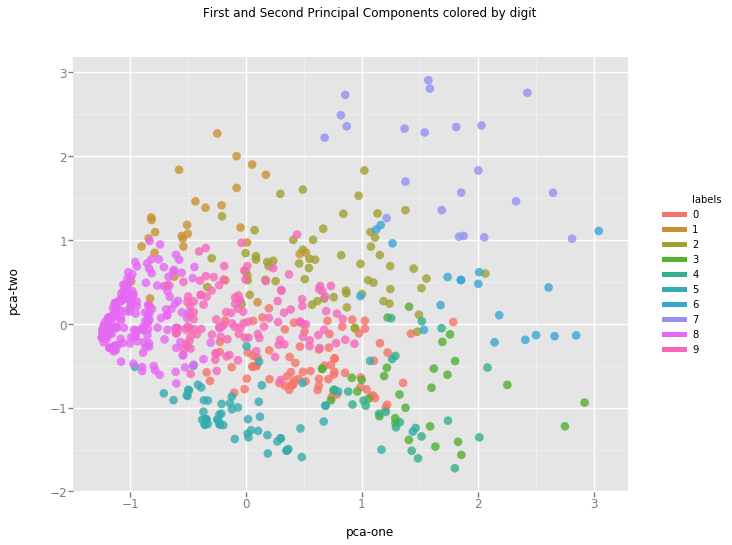

<ggplot: (7543647333)>

In [52]:
pca_one = pca_result[:, 0]
pca_two = pca_result[:, 1]

df_hero_pca = pd.DataFrame({'pca-one': pca_one, 'pca-two': pca_two, 'labels': hero_df['label']})
chart = ggplot( df_hero_pca, aes(x='pca-one', y='pca-two', color='labels') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")
chart

In [53]:
# try t-SNE to decrease dimensions and get better visualization

tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300)
tsne_results = tsne.fit_transform(h_vector)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 667 samples in 0.015s...
[t-SNE] Computed neighbors for 667 samples in 0.153s...
[t-SNE] Computed conditional probabilities for sample 667 / 667
[t-SNE] Mean sigma: 0.632713
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.868530
[t-SNE] KL divergence after 300 iterations: 1.405167


In [54]:
print(k_means_labels.shape)

(667,)


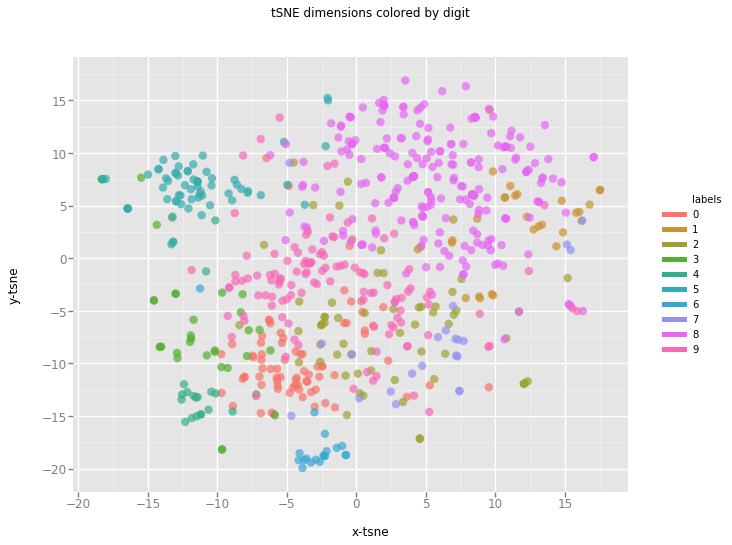

<ggplot: (7543357349)>

In [55]:
df_tsne = pd.DataFrame({'x-tsne': tsne_results[:,0], 'y-tsne': tsne_results[:, 1], 'labels': hero_df['label']})
chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='labels') ) \
        + geom_point(size=70,alpha=0.7) \
        + ggtitle("tSNE dimensions colored by digit") \

chart